In [8]:
from IPython.core.display import display, HTML

 

display(HTML("<style>.container { width: 85% !important; }</style>"))

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

# 데이터 로드

In [25]:
patient = pd.read_csv('/project/data/PATIENTS.csv')
lab = pd.read_csv('/project/data/LABEVENTS.csv', usecols = ['ROW_ID','SUBJECT_ID','HADM_ID','ITEMID','CHARTTIME','FLAG'])

#D_ICD_DIAGNOSES
diagnoses = pd.read_csv('/project/data/D_ICD_DIAGNOSES.csv')
#DIAGNOSES_ICD
diagnoses_icd = pd.read_csv('/project/data/DIAGNOSES_ICD.csv')

In [9]:
#폐와 관련된 질병 추출
diag_pneum = diagnoses[(diagnoses['SHORT_TITLE'].str.contains('pneum')|(diagnoses['SHORT_TITLE'].str.contains('Pneum')))]
diag_pneum.shape

(95, 4)

In [10]:
# 폐와 관련된 질병의 value_counts - 가장 많은 코드 486, 5070, 48241만 사용하기로 함
pneum_id = diagnoses_icd[diagnoses_icd['ICD9_CODE'].isin(diag_pneum['ICD9_CODE'])].reset_index()
pneum_id['ICD9_CODE'].value_counts()[:10]

486      4839
5070     3680
48241     789
5121      786
99731     564
0413      473
4821      430
8600      375
48283     264
4829      227
Name: ICD9_CODE, dtype: int64

In [11]:
#[:3] 정확한 병명 확인
diagnoses[diagnoses['ICD9_CODE'].isin(pneum_id['ICD9_CODE'].value_counts()[:3].index)]

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
5129,5509,48241,Meth sus pneum d/t Staph,Methicillin susceptible pneumonia due to Staph...
5147,5528,486,"Pneumonia, organism NOS","Pneumonia, organism unspecified"
5407,5136,5070,Food/vomit pneumonitis,Pneumonitis due to inhalation of food or vomitus


In [12]:
#[:3]의 Diagnoses_icd 데이터 추출
pneum = pneum_id[(pneum_id['ICD9_CODE'].isin(pneum_id['ICD9_CODE'].value_counts()[:3].index))].drop(['index','ROW_ID','SEQ_NUM'],axis=1).reset_index(drop=True)
pneum

,SUBJECT_ID,HADM_ID,ICD9_CODE
0,109,172335,486
1,117,164853,486
2,124,112906,486
3,124,138376,486
4,136,184644,486
...,...,...,...
9303,95555,103704,486
9304,95561,121289,486
9305,95816,122432,5070
9306,95816,122432,486


In [13]:
# 환자의 id만 추출하여 환자id에 저장, 총 예측에 사용할 환자 수 확인
환자id = pneum['SUBJECT_ID'].unique()
len(환자id)

7807

In [14]:
# 추출한 환자id로 환자의 사망,생존 분포 확인
patient[patient['SUBJECT_ID'].isin(환자id)]['EXPIRE_FLAG'].value_counts()

1    4777
0    3030
Name: EXPIRE_FLAG, dtype: int64

In [15]:
#추출한 환자id로 patient에서 정보 추출
환자 = patient[patient['SUBJECT_ID'].isin(환자id)]
환자

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0
17,251,268,F,2132-02-21 00:00:00,2198-02-18 00:00:00,2198-02-18 00:00:00,NaN,1
18,252,269,M,2130-09-30 00:00:00,NaN,NaN,NaN,0
22,628,665,M,2052-05-20 00:00:00,2120-02-04 00:00:00,2120-02-04 00:00:00,NaN,1
...,...,...,...,...,...,...,...,...
46476,31801,43932,M,2080-06-26 00:00:00,2153-03-01 00:00:00,NaN,2153-03-01 00:00:00,1
46477,31802,43937,M,2113-03-30 00:00:00,2200-08-05 00:00:00,2200-08-05 00:00:00,2200-08-05 00:00:00,1
46482,31807,43959,F,2028-05-13 00:00:00,NaN,NaN,NaN,0
46488,31813,43982,F,2065-04-17 00:00:00,NaN,NaN,NaN,0


In [16]:
환자.to_csv('폐렴환자.csv', index=False)

# labevents에서 폐렴환자 추출 및 간단 EDA

In [17]:
# labevents에서 폐렴환자 id만을 추출하여 환자lab에 저장
환자lab = lab[lab['SUBJECT_ID'].isin(환자id)].reset_index(drop=True)
환자lab

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,FLAG
0,5144,9,150750.0,50819,2149-11-14 06:07:00,NaN
1,5145,9,150750.0,50820,2149-11-14 06:07:00,NaN
2,5146,9,150750.0,50821,2149-11-14 06:07:00,abnormal
3,5147,9,150750.0,50826,2149-11-14 06:07:00,NaN
4,5148,9,150750.0,50827,2149-11-14 06:07:00,NaN
...,...,...,...,...,...,...
9356344,27427231,96442,120151.0,51248,2115-06-29 04:45:00,NaN
9356345,27427232,96442,120151.0,51249,2115-06-29 04:45:00,NaN
9356346,27427233,96442,120151.0,51250,2115-06-29 04:45:00,NaN
9356347,27427234,96442,120151.0,51254,2115-06-29 04:45:00,abnormal


In [18]:
# value_counts()를 위해 결측치를 문자열 'nan' 으로 설정
환자lab['FLAG'] = 환자lab['FLAG'].fillna('nan')

In [19]:
환자lab['FLAG'].value_counts()

nan         5931403
abnormal    3406609
delta         18337
Name: FLAG, dtype: int64

In [20]:
환자lab.to_csv('폐렴환자lab.csv', index=False)

<AxesSubplot:xlabel='FLAG', ylabel='count'>

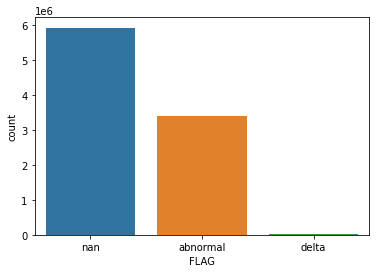

In [21]:
import seaborn as sns
sns.countplot(환자lab['FLAG'])

In [22]:
# 전체 ITEMID의 개수 확인
환자lab['ITEMID'].nunique()

690

In [23]:
# abnormal인 환자별로 ITEMID 개수 확인
환자lab[환자lab['FLAG'].str.contains('abnormal')].groupby(['SUBJECT_ID'])['ITEMID'].count()

SUBJECT_ID
9        113
21       646
31       149
36       665
37        91
        ... 
99863    320
99934     47
99937     46
99944     90
99985    305
Name: ITEMID, Length: 7799, dtype: int64

In [24]:
#외래환자
list(set(환자id) - set(환자lab['SUBJECT_ID'].unique()))

[60961, 48968, 17674, 9388, 19097, 93114, 58012, 95230]